<!-- Notebook Header Start -->

<h1 align="center">Analysis of Evoked Compount Action Potential</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2024-11-18<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Lab  || Neuromechatronics Lab
</p>

---


## 📊 Notebook Outline

* **Import libraries, files, probe**
  * Important probe
  * Define import and export folders
* **Perform preprocessing, ECAP analysis, etc, in SpikeInterface**



## 📚 References & Additional Resources

- [Kilosort4 docs](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface docs](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# 📈 Importing Libraries & Data
---

## import libraries & custom functions

In [ ]:
# standard imports
from pathlib import Path
import os
import pandas as pd
import numpy as np
from kilosort import io
import matplotlib.pyplot as plt

# custom imports
from automations import RM1
from automations import Kilosort_wrapper
from automations import SpikeInterface_wrapper
from automations import plots

## probe definition

Using the spreadsheet, `Adapter_pinout.xlsx`, the contact ID's can be traced to the "device channel", and we can assign them on the probe. 

In this case, our channel indices correspond to the aux inputs to the intan headstage.

refer to the notebook, `RM1_pipeline.ipynb` within  the `dev_notebook` folder

In [2]:
### Path definitions

# NOTE: this script will work if you point the save directory to a folder specific to this rat
# make sure to create the folders: binary & figures
SAVE_DIRECTORY = Path(fr'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW327') 

# NOTE: this data used in this script come from a folder with multiple rats. if you point the data 
# directory to a different folder, make sure that it has the same folder structure.
DATA_DIRECTORY = Path(fr'D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project') 
# Create paths if they doesn't exist
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)
SAVE_DIRECTORY.mkdir(parents=True, exist_ok=True)
PROBE_DIRECTORY = Path(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.001 A1x32-Edge-5mm-20-177-A32\A1x32-Edge-5mm-20-177-A32.prb')

# 🔬 Exploratory Data Analysis (EDA)

see paper for more information. for this experiment, I elected to start my analysis with trial: 

**Rat: DW322 | Trial: DRGS_1_240918_125448**

In [3]:
Rat = RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, "DW323")

Reading DRGS_10_240911_155921...
Error reading stream 2 for DRGS_10_240911_155921. continuing...
Reading DRGS_11_240911_160638...
Error reading stream 2 for DRGS_11_240911_160638. continuing...
Reading DRGS_1_240911_144910...
Error reading stream 2 for DRGS_1_240911_144910. continuing...
Reading DRGS_2_240911_145808...
Error reading stream 2 for DRGS_2_240911_145808. continuing...
Reading DRGS_3_240911_150506...
Error reading stream 2 for DRGS_3_240911_150506. continuing...
Reading DRGS_4_240911_151137...
Error reading stream 2 for DRGS_4_240911_151137. continuing...
Reading DRGS_5_240911_151925...
Error reading stream 2 for DRGS_5_240911_151925. continuing...
Reading DRGS_6_240911_152522...
Error reading stream 2 for DRGS_6_240911_152522. continuing...
Reading DRGS_7_240911_153255...
Error reading stream 2 for DRGS_7_240911_153255. continuing...
Reading DRGS_8_240911_154319...
Error reading stream 2 for DRGS_8_240911_154319. continuing...
Reading DRGS_9_240911_155057...
Error reading 

### Metadata for each trial

In [4]:

print(f'stimulating amplitude: {Rat.mat_files_dict["DRGS_6_152522"]["AM"]["amp"][0, 0][0, 0]} uA')
print(f'recruitment amplitudes: {Rat.mat_files_dict["DRGS_6_152522"]["AM"]["rcrtrange_num"][0, 0][0][:]} uA')


stimulating amplitude: 70 uA
recruitment amplitudes: [69 70 71 72 73 74 75 76 77] uA


### 📑 metadata - VF experiment notes

In [5]:
Rat.qst_experiment_notes

'd1 tl, d2 am sync, a1 am monitor,a2 evf'

### 📑 metadata - DRGS trial notes

In [6]:
Rat.drgs_trial_notes.head()

5            Trial Number Condition amp (uA) PW (us) Freq. (Hz) Dur. (s)  \
Trial Number                                                               
1                       1      DRGS       70     300          5      180   
2                       2      DRGS       70     300          5      180   
3                       3      DRGS       70     300        100      180   
4                       4      DRGS       70     300        100      180   
5                       5      DRGS       70     300         20      180   

5            Stimuli Stage Stimuli Dur.  rcrtrange waitime  
Trial Number                                                
1                NaN   NaN           NaN     69,77      30  
2                NaN   NaN           NaN     69,77      30  
3                NaN   NaN           NaN     69,77      30  
4                NaN   NaN           NaN     69,77      30  
5                NaN   NaN           NaN     69,77      30

collect spinal cord data

In [7]:
Rat.get_sc_data()
Rat.sc_data.keys()

dict_keys(['DRGS_10_240911_155921', 'DRGS_11_240911_160638', 'DRGS_1_240911_144910', 'DRGS_2_240911_145808', 'DRGS_3_240911_150506', 'DRGS_4_240911_151137', 'DRGS_5_240911_151925', 'DRGS_6_240911_152522', 'DRGS_7_240911_153255', 'DRGS_8_240911_154319', 'DRGS_9_240911_155057', 'nninsertion_240911_130746', 'nn_seond_insertion_240911_144433', 'QST_2_240911_181341', 'VF_1_240911_164342', 'VF_2_240911_165039', 'VF_3_240911_165617', 'VF_4_240911_170446', 'VF_5_240911_171014', 'VF_6_240911_171505', 'VF_7_240911_180931'])

### process data for import into Kilosort

I will use a combination of `SpikeInterface` & `Kilosort.io.extractors` to get the data I need

In [8]:
signals = SpikeInterface_wrapper(Rat, SAVE_DIRECTORY)

Preparing SpikeInterface wrapper for rat DW323


In [9]:
TRIAL_DRGS = "DRGS_11_240911_160638"
TRIAL_VF = ""

In [10]:
Rat.drgs_trial_notes.loc[11].to_latex(os.path.join(SAVE_DIRECTORY, "tables", "drgs_trial_notes.tex"), 
                                        header=False,
                                        )
Rat.drgs_trial_notes.loc[11]

5
Trial Number        11
Condition         DRGS
amp (uA)            70
PW (us)            300
Freq. (Hz)          20
Dur. (s)           180
Stimuli            NaN
Stage              NaN
Stimuli Dur.       NaN
rcrtrange        69,77
waitime             60
Name: 11, dtype: object

## 📈 signals

In [11]:
Rat.intan_recordings_stream0[TRIAL_DRGS]

IntanRecordingExtractor: 34 channels - 30.0kHz - 1 segments - 8,745,728 samples 
                         291.52s (4.86 minutes) - uint16 dtype - 567.16 MiB
  file_path: D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project\DW323\DW323\DRGS_11_240911_160638\DRGS_11_240911_160638.rhd

In [12]:
Rat.intan_recordings_stream1[TRIAL_DRGS]

IntanRecordingExtractor: 6 channels - 7500.0Hz - 1 segments - 2,186,432 samples 
                         291.52s (4.86 minutes) - uint16 dtype - 25.02 MiB
  file_path: D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project\DW323\DW323\DRGS_11_240911_160638\DRGS_11_240911_160638.rhd

In [13]:
Rat.intan_recordings_stream3[TRIAL_DRGS]

IntanRecordingExtractor: 2 channels - 30.0kHz - 1 segments - 8,745,728 samples 
                         291.52s (4.86 minutes) - uint16 dtype - 33.36 MiB
  file_path: D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project\DW323\DW323\DRGS_11_240911_160638\DRGS_11_240911_160638.rhd

In [14]:
Rat.intan_recordings_stream4[TRIAL_DRGS]


IntanRecordingExtractor: 2 channels - 30.0kHz - 1 segments - 8,745,728 samples 
                         291.52s (4.86 minutes) - uint16 dtype - 33.36 MiB
  file_path: D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project\DW323\DW323\DRGS_11_240911_160638\DRGS_11_240911_160638.rhd

In [15]:
Rat.sc_data[TRIAL_DRGS]

ChannelSliceRecording: 32 channels - 30.0kHz - 1 segments - 8,745,728 samples 
                       291.52s (4.86 minutes) - uint16 dtype - 533.80 MiB

In [16]:
recording = Rat.sc_data[TRIAL_DRGS]

In [17]:
# Get all channel IDs
channel_ids = recording.get_channel_ids()

# Find the index of channel 'A-000'
try:
    channel_idx = list(channel_ids).index('A-000')
except ValueError:
    raise ValueError("Channel 'A-000' not found in the recording.")

channel_ids

array(['A-000', 'A-001', 'A-002', 'A-003', 'A-004', 'A-005', 'A-006',
       'A-007', 'A-008', 'A-009', 'A-010', 'A-011', 'A-012', 'A-013',
       'A-014', 'A-015', 'A-016', 'A-017', 'A-018', 'A-019', 'A-020',
       'A-021', 'A-022', 'A-023', 'A-024', 'A-025', 'A-026', 'A-027',
       'A-028', 'A-029', 'A-030', 'A-031'], dtype='<U64')

In [18]:
plots.interactive_trace(recording, channel_id="A-000", downsample_factor=100)

gain_to_uV: 0.195, offset_to_uV: -6389.76


gain_to_uV: 0.195, offset_to_uV: -6389.76


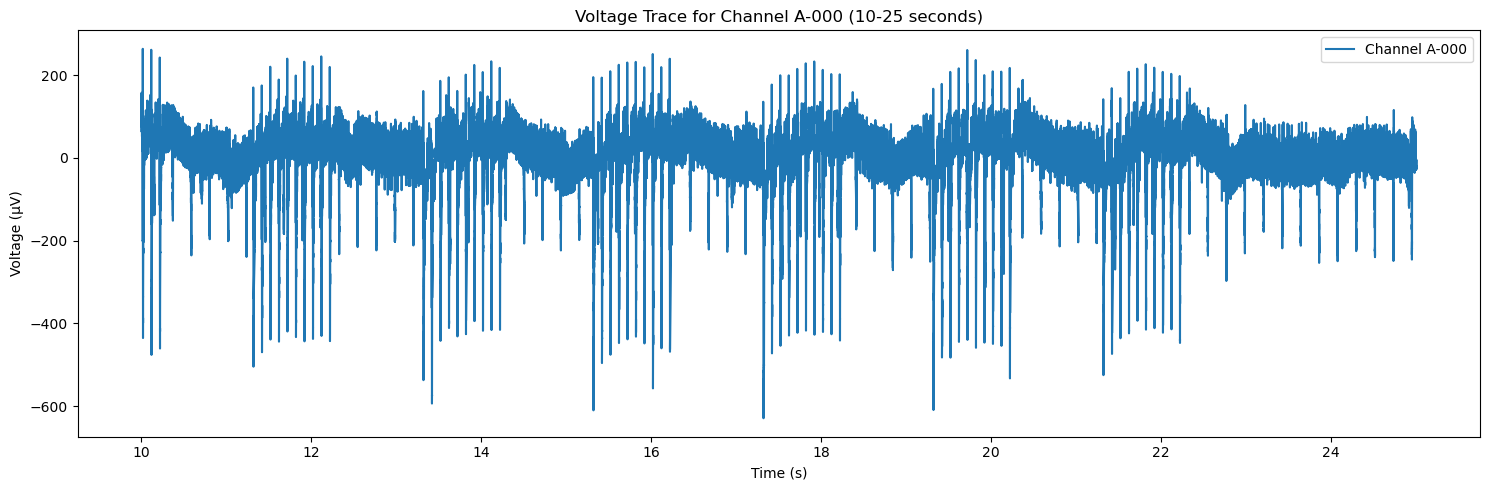

In [30]:
plots.static_trace(recording, channel_id="A-001",start_time=10, end_time=25)